In [77]:
from PIL import Image as IMG
import numpy as np
from pprint import pprint
import pandas as pd
import runs as R
import numpy as np
import os
sep = os.sep
import matplotlib.pyplot as plt
import runs
from core.measurements import Prf1a

### Generate 'Normal' Metrics

In [78]:
def theta(pred, label):
    u1 = pred/np.linalg.norm(pred, axis=2)[..., None]
    u2 = label/np.linalg.norm(label, axis=2)[..., None]
    dot = np.einsum('ijk,ijk->ij', u1, u2)
    theta = np.rad2deg(np.arccos(np.clip(dot, -1.0, 1.0)))
    return theta

In [79]:
img_dir = 'EVALDATA/Image/' 
norm_gt_dir = 'EVALDATA/'+os.sep+'GT_norm'
norm_pred_dir = 'EVALDATA/'+os.sep+'Preds'+os.sep+'Norm'

In [80]:
L1, L1_sum = 0, 0
L2, L2_sum = 0, 0
L3, L3_sum = 0, 0
for file in os.listdir(img_dir):
    img = np.array(IMG.open(img_dir + os.sep + file))
    gt_norm = np.array(IMG.open(norm_gt_dir+os.sep+file))[:,:,0:3]
    pred_norm = np.array(IMG.open(norm_pred_dir+os.sep+file.split('.')[0]+'_pred.png'))
    
    th = theta(pred_norm, gt_norm)

    L1 += (th<11.5).astype(int).sum()
    L1_sum += th.size

    L2 += (th<22.5).astype(int).sum()
    L2_sum += th.size

    L3 += (th<30).astype(int).sum()
    L3_sum += th.size

In [81]:
print('L1: ', L1/L1_sum)
print('L2: ', L2/L2_sum)
print('L3: ', L3/L3_sum)

L1:  0.9430167643229167
L2:  0.9725838216145833
L3:  0.9826481119791667


### Generate Segmentation overlap

In [82]:
def get_lbl_from_gt(cname, gt):
    r, g, b = runs.CLASS_RGB[cname]
    lbl = np.zeros_like(gt[:,:,1])
    logic = np.logical_and.reduce( [gt[:, :, 0] == r, gt[:, :, 1] == g, gt[:, :, 2] == b])
    ix = np.array(list(zip(*np.where(logic))))
    if len(ix) > 0:
        lbl[ix[:,0], ix[:,1]] = 255
    return lbl

In [83]:
def get_lbl_from_pred(cname, pred):
    cls = runs.CLASS_LABELS[cname]
    lbl = np.zeros_like(pred)
    ix = np.array(list(zip(*np.where(pred==cls))))
    if len(ix) > 0:
        lbl[ix[:,0], ix[:,1]] = 255
    return lbl

In [84]:
img_dir = 'EVALDATA/Image/' 
seg_gt_dir = 'EVALDATA/'+os.sep+'GT_seg'
seg_pred_dir = 'EVALDATA/'+os.sep+'Preds'+os.sep+'Seg'

In [85]:
overlap = {}.fromkeys(runs.CLASS_LABELS, None)
for k in overlap:
    overlap[k] = Prf1a()
    
for file in os.listdir(img_dir):
    img = np.array(IMG.open(img_dir + os.sep + file))
    gt_seg = np.array(IMG.open(seg_gt_dir+os.sep+file))[:,:,0:3]
    npy_seg =  np.load(seg_pred_dir+os.sep+file.split('.')[0]+'_pred.npy')
    for obj in runs.CLASS_RGB:
        lbl = get_lbl_from_gt(obj, gt_seg)
        pred = get_lbl_from_pred(obj, npy_seg)
        if lbl.sum()>0: # if obj is in gt
            overlap[obj].add_array(pred, lbl)

In [67]:
o = []
for obj in overlap:
    o.append( overlap[obj].overlap)
    print(obj, overlap[obj].overlap)
print('Average: ', sum(o)/len(o))

Other 0.84079
Table 0.91065
Shelve 0.98364
Book 0.90388
Couch 0.99456
Frame 0.98564
Lamp 0.95145
Plant 0.75344
Rug 0.99073
Wall 0.99651
Floor 0.99753
TV 0.98793
Window 0.001
Curtain 0.99082
Door 0.99186
Average:  0.885362


### Generate RGB classes from prediction

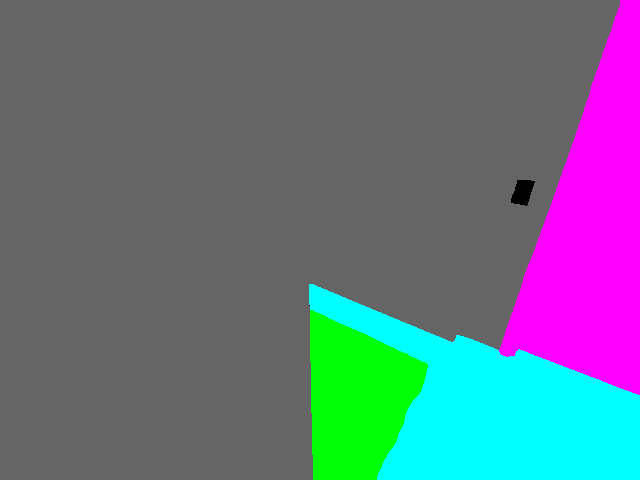

In [85]:
rgb = np.zeros((npy_seg.shape[0], npy_seg.shape[1], 3), dtype=np.uint8)
for cname, lbl in runs.CLASS_LABELS.items():
    crgb = runs.CLASS_RGB[cname]
    i, j = np.where(npy_seg==lbl)
    rgb[i, j, :] = np.array(crgb)
IMG.fromarray(rgb)